In [4]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Model </h1>

I consider the decay of a 2-level atom into the cavity. I work in the subspace:
$$ \ket{1,0}, \ket{0,1} $$

And the Hamiltonian is given by: 

$$ H = \sum_k \omega_k a_k^{\dagger} a_k + \frac{1}{2} \sum_j \Omega_j (1 + \sigma_j^z) + \sum_{k,j}\left\{g(k,j) \sigma^+ a_k + \text{h.c} \right\} $$

with $g(k,j) = i g_0 \sqrt{\omega_k} e^{ikx_j}$

<h1> Conduct time evolution </h1>

In [9]:
def get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, n_A, g_0, x_A, sigma, x_0, use_WW_approx = True, print_nb_modes = False):
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)

    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #tab of couplings
    g_tab = np.zeros((n_modes, n_A), dtype=complex)
    for i in range(n_modes):
        for j in range(n_A):
            if use_WW_approx:
                g_tab[i, j] = g_0*np.sqrt(omega_A / L)*np.exp(-1j*x_A*k_tab[i])*1j
            else:
                g_tab[i, j] = g_0*np.sqrt(omega_tab[i] / L)*np.exp(-1j*x_A*k_tab[i])*1j #in my case, g is independant of the atom index

    #Creation of the Hamiltonian
    dim_subspace = n_modes + n_A
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    ##diagonal elements
    for i in range(n_modes):
        H_matrix[i, i] = omega_tab[i]
    for i in range(n_A):
        H_matrix[n_modes+i, n_modes+i] = omega_A

    ##off diagonal elements
    for i in range(n_modes):
        for j in range(n_A):
            H_matrix[n_modes+j, i] = g_tab[i, j]
            H_matrix[i,n_modes+j] = np.conjugate(H_matrix[n_modes+j,i])

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None

    ##Operators of interest
    N_k_list = []
    N_A = 0

    #occupation number operators in momentum space
    for i in range(n_modes):
        N_k_list.append(qt.basis(dim_subspace, i) * qt.basis(dim_subspace, i).dag())

    for j in range(n_A):
        N_A += qt.basis(dim_subspace, n_modes + j) * qt.basis(dim_subspace, n_modes + j).dag()

    ##Initial state : the atom is excited 
    init_state = qt.basis(dim_subspace, n_modes) 

    #time evolution
    nb_pts = int(T/dt)
    times = np.linspace(0, T, nb_pts)
    result = qt.sesolve(H, init_state, times, e_ops= N_k_list + [N_A], options={"nsteps":10000, "progress_bar": True})
    
    N_k_tab = result.expect[:n_modes]
    N_A_tab = result.expect[-1]
  

    return times, k_tab, N_k_tab, N_A_tab

First test of the function

In [27]:
L = 20*pi
T = L
dt = 0.1

#number of atom
n_A = 1
x_A = 0

#width of the wave packet
sigma = L/8
x_0 = -L/4


#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.1
omega_A = 5
omega_0 = omega_A 

print("omega_A = ", omega_A," and omega_0 =", omega_0)

omega_max = 2*omega_A

print("Coupling parameter at atom frequency: ", g_0*np.sqrt(omega_A / L))
print("delta_k = ", 2*pi/L)
print("number of time points = ", int(T/dt))

times, k_tab, N_k_tab, N_A_tab  = get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, n_A, g_0, x_A, sigma, x_0, print_nb_modes=True)

N_k_tab = np.array(N_k_tab)

omega_A =  5  and omega_0 = 5
Coupling parameter at atom frequency:  0.028209479177387815
delta_k =  0.1
number of time points =  628
Number of modes:  201
10.0%. Run time:   0.66s. Est. time left: 00:00:00:05
20.1%. Run time:   1.48s. Est. time left: 00:00:00:05
30.1%. Run time:   2.30s. Est. time left: 00:00:00:05
40.0%. Run time:   3.05s. Est. time left: 00:00:00:04
50.1%. Run time:   3.86s. Est. time left: 00:00:00:03
60.1%. Run time:   4.75s. Est. time left: 00:00:00:03
70.0%. Run time:   5.47s. Est. time left: 00:00:00:02
80.1%. Run time:   6.25s. Est. time left: 00:00:00:01
90.1%. Run time:   7.00s. Est. time left: 00:00:00:00
100.0%. Run time:   7.70s. Est. time left: 00:00:00:00
Total run time:   7.71s


<h2> Inspect occupation number of the atom </h2>

In [28]:
#theoretical prediction
gamma = 2* g_0**2 *omega_A
tau = 1/gamma
test_curve = np.exp(-gamma*times)

Life time of the atom:  9.999999999999998
Excitation at lifetime:  0.3694449931987267


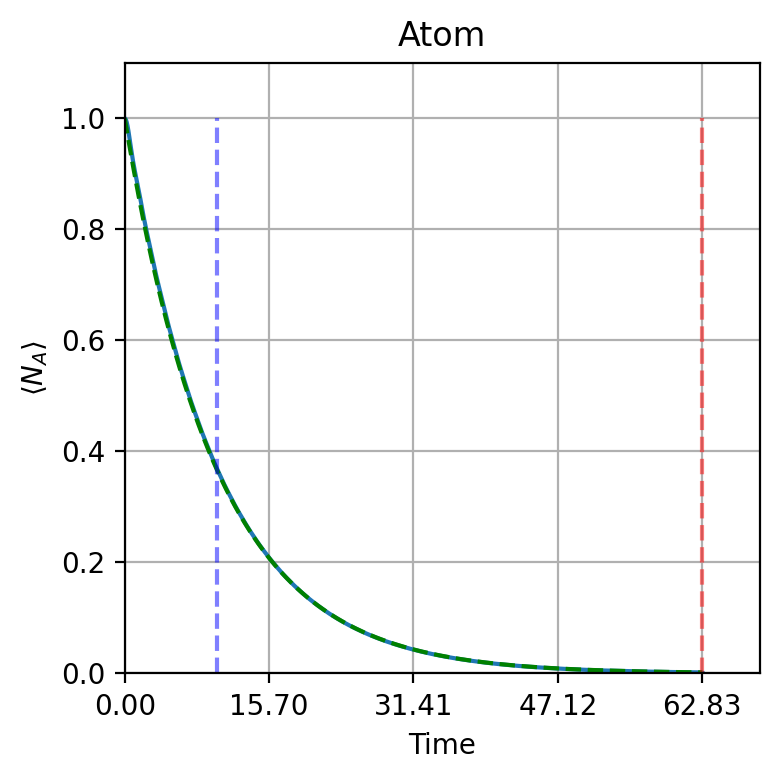

In [29]:
print("Life time of the atom: ", tau)

#Look for the value of the excitation at lifetime
tau_index = np.argmin(np.abs(times - tau))
excitation_at_tau = N_A_tab[tau_index]
print("Excitation at lifetime: ", excitation_at_tau)

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=resol)

ax.plot(times, N_A_tab)
#some test
ax.plot(times, test_curve, linestyle='--', color='green', label=r"$\exp(-\gamma t)$")
ax.set_xlim(0, 1.1*times[-1])
ax.set_xticks(np.floor(100*np.array([0, T/4, T/2, 3*T/4, T]))/100)
ax.set_xlabel('Time')
ax.vlines(L, 0, 1, color='r', linestyle='--', alpha=0.5)
ax.vlines(tau, 0, 1, color='b', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1.1*np.max(N_A_tab))
ax.set_ylabel(r'$\langle N_A \rangle$')
ax.set_title("Atom")
ax.grid()

fig.tight_layout()
plt.show()